In [43]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from nflows.distributions.normal import StandardNormal

In [9]:
seed = 42
np.random.seed(seed)

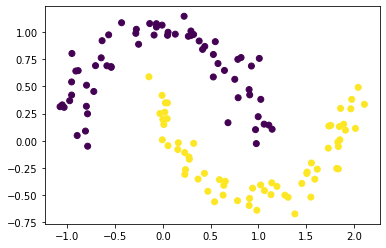

In [10]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1], c=y);

In [44]:
num_layers = 3

# base_dist = ConditionalDiagonalNormal(
#     shape=[2], context_encoder=nn.Linear(1, 4),
#     )
base_dist = StandardNormal([2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(
        MaskedAffineAutoregressiveTransform(
            features=2, hidden_features=128, context_features=1,
            )
        )
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

 10%|█████▉                                                      | 499/5000 [00:08<01:14, 60.17it/s]

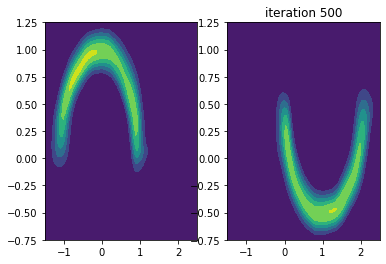

 20%|███████████▉                                                | 998/5000 [00:17<01:07, 59.69it/s]

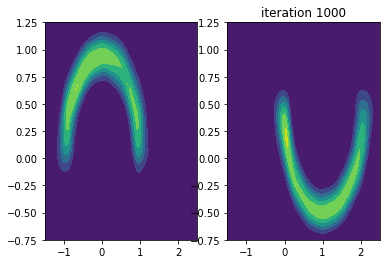

 30%|█████████████████▋                                         | 1495/5000 [00:25<00:48, 71.64it/s]

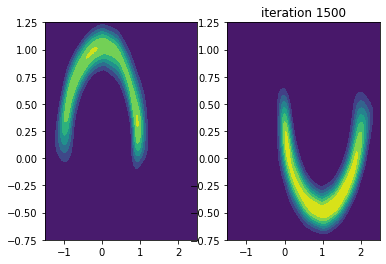

 40%|███████████████████████▌                                   | 1993/5000 [00:33<00:44, 67.01it/s]

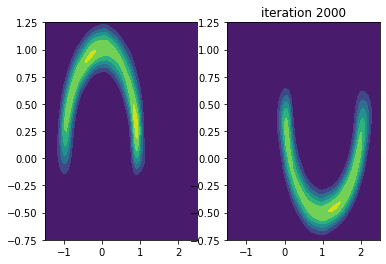

 50%|█████████████████████████████▍                             | 2492/5000 [00:41<00:43, 57.91it/s]

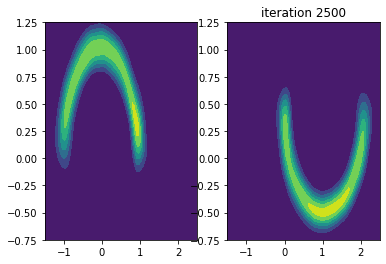

 60%|███████████████████████████████████▍                       | 2998/5000 [00:50<00:35, 56.92it/s]

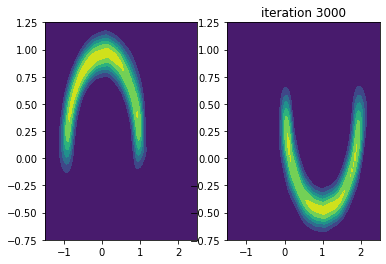

 70%|█████████████████████████████████████████▎                 | 3499/5000 [00:58<00:27, 55.22it/s]

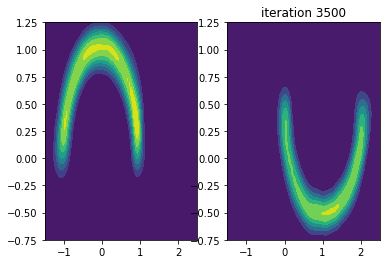

 80%|███████████████████████████████████████████████▏           | 3997/5000 [01:06<00:16, 61.90it/s]

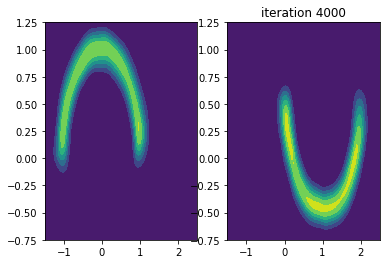

 90%|█████████████████████████████████████████████████████      | 4499/5000 [01:15<00:07, 66.39it/s]

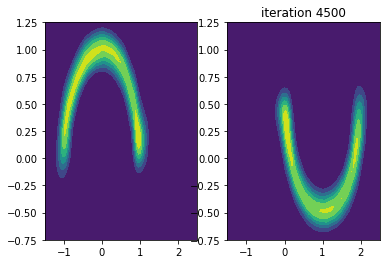

100%|██████████████████████████████████████████████████████████▉| 4993/5000 [01:23<00:00, 61.84it/s]

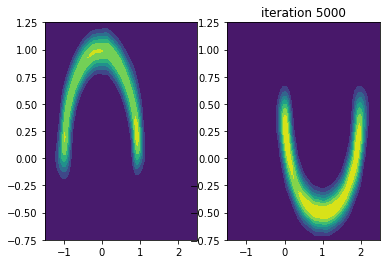

100%|███████████████████████████████████████████████████████████| 5000/5000 [01:24<00:00, 59.34it/s]


In [45]:
num_iter = 5000

for i in tqdm(range(num_iter)):
    
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()